In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
from keras.layers import  Lambda
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

In [0]:
img_height, img_width, channel = train_features.shape[1],train_features.shape[2],train_features.shape[3]

In [0]:
from keras.layers import Input
input = Input(shape=(img_height, img_width, channel))

In [0]:
input

<tf.Tensor 'input_2:0' shape=(?, 32, 32, 3) dtype=float32>

In [0]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,SeparableConv2D
from keras.layers import concatenate


#5,5 seperable convolution, I consider this as depthwise seperable convolution as mentioned in the class
layer1 = SeparableConv2D(32,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_1',use_bias=False)(input)
layer1 = Dropout(0.2)(layer1)
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation('relu')(layer1)

skip_connection1 = layer1

#Normal 5,5 convolution
layer2 = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', use_bias=False,dilation_rate = 1)(layer1)
layer2 = Dropout(0.2)(layer2)
layer2 = BatchNormalization(name='norm_2')(layer2)
layer2 = Activation('relu')(layer2)

skip_connection2 = layer2

#Nomal 5,5 convolution
layer3 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_2', use_bias=False,dilation_rate = 1)(layer2)
layer3 = Dropout(0.2)(layer3)
layer3 = BatchNormalization(name='norm_3')(layer3)
layer3 = Activation('relu')(layer3)

skip_connection3 = layer3

#matching the resolution to concatenate with layer3

layerin = concatenate([layer3,skip_connection1])


#5,5 seperable convolution, I consider this as depthwise seperable convolution as mentioned in the class
layer4 = SeparableConv2D(128,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_2',use_bias=False)(layerin)
layer4 = Dropout(0.2)(layer4)
layer4 = BatchNormalization(name='norm_4')(layer4)
layer4 = Activation('relu')(layer4)

skip_connection4 = layer4

layerin1 = concatenate([layer4,skip_connection1])

#Transition block
layer5 = MaxPooling2D(pool_size=(2, 2))(layerin1)
layer5 = Conv2D(32, (1,1),padding='same',use_bias=False)(layer5)
layer5 = BatchNormalization(name='norm_5')(layer5)
layer5 = Activation('relu')(layer5)

#3,3 seperable convolutin,depthwise
layer6 = SeparableConv2D(32,(3,3), strides=(1,1), padding = 'same',name= 'depthwise_3',use_bias=False)(layer5)
layer6 = Dropout(0.2)(layer6)
layer6 = BatchNormalization(name='norm_6')(layer6)
layer6 = Activation('relu')(layer6)

skip_connection6=layer6

layerin2 = Lambda(space_to_depth_x2)(layerin1)
layerin3=concatenate([layerin2,layer6])

#5,5 normal convolution
layer7 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_3', use_bias=False,dilation_rate = 1)(layerin3)
layer7 = Dropout(0.2)(layer7)
layer7 = BatchNormalization(name='norm_7')(layer7)
layer7 = Activation('relu')(layer7)

skip_connection7=layer7

layerin4 =concatenate([skip_connection3,skip_connection4])
layerin4 = Lambda(space_to_depth_x2)(layerin4)
layerin5= concatenate([layerin4,skip_connection6])
layerin5=concatenate([layerin5,layer7])

#3,3 seperable convolution,depthwise
layer8 = SeparableConv2D(64,(3,3), strides=(1,1), padding = 'same',name= 'depthwise_4',use_bias=False)(layerin5)
layer8 = Dropout(0.2)(layer8)
layer8 = BatchNormalization(name='norm_8')(layer8)
layer8 = Activation('relu')(layer8)

skip_connection8=layer8

layerin6=concatenate([skip_connection1,skip_connection3])
layerin7=concatenate([layerin6,skip_connection4])
layerin7=Lambda(space_to_depth_x2)(layerin7)
layerin8=concatenate([layerin7,skip_connection6])
layerin9=concatenate([layerin8,skip_connection7])
layerin9=concatenate([layerin9,layer8])

##5,5sperable convolution,depthwise
layer9 = SeparableConv2D(128,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_5',use_bias=False)(layerin9)
layer9 = Dropout(0.2)(layer9)
layer9 = BatchNormalization(name='norm_9')(layer9)
layer9 = Activation('relu')(layer9)

skip_connection9= layer9

layerin10=concatenate([layerin3,skip_connection8])
layerin10=concatenate([layerin10,layer9])

#Transition block
layer10 = MaxPooling2D(pool_size=(2, 2))(layerin10)
layer10 = Conv2D(32, (1,1),padding='same',use_bias=False)(layer10)
layer10 = BatchNormalization(name='norm_10')(layer10)
layer10 = Activation('relu')(layer10)

skip_connection10=layer10

layerin11=Lambda(space_to_depth_x2)(skip_connection7)
layerin11=concatenate([layerin11,layer10])

#5,5 normal convolutions
layer11 = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_4', use_bias=False,dilation_rate = 1)(layerin11)
layer11 = Dropout(0.2)(layer11)
layer11= BatchNormalization(name='norm_11')(layer11)
layer11= Activation('relu')(layer11)

skip_connection11=layer11

layerin12=concatenate([skip_connection2,skip_connection4])
layerin12=Lambda(space_to_depth_x2)(layerin12)
layerin13=concatenate([layerin12,skip_connection8])
layerin13=Lambda(space_to_depth_x2)(layerin13)
layerin13=concatenate([layerin13,layer11])


#5,5 seperable convolution,depthwise
layer12 = SeparableConv2D(64,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_6',use_bias=False)(layerin13)
layer12 = Dropout(0.2)(layer12)
layer12= BatchNormalization(name='norm_12')(layer12)
layer12= Activation('relu')(layer12)

skip_connection12=layer12

layerin14=concatenate([skip_connection2,skip_connection3])
layerin14=Lambda(space_to_depth_x2)(layerin14)
layerin15=concatenate([layerin14,skip_connection6])
layerin15=Lambda(space_to_depth_x2)(layerin15)
layerin16=concatenate([layerin15,skip_connection11])
layerin16=concatenate([layerin16,layer12])

#3,3 normal convolutions
layer13 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False,dilation_rate = 1)(layerin16)
layer13 = Dropout(0.2)(layer13)
layer13= BatchNormalization(name='norm_13')(layer13)
layer13= Activation('relu')(layer13)

skip_connection13=layer13

layerin17=concatenate([skip_connection1,skip_connection3])
layerin18=concatenate([layerin17,skip_connection4])
layerin18=Lambda(space_to_depth_x2)(layerin18)
layerin19=concatenate([layerin18,skip_connection6])
layerin20=concatenate([layerin19,skip_connection8])
layerin20=Lambda(space_to_depth_x2)(layerin20)
layerin21=concatenate([layerin20,skip_connection12])
layerin21=concatenate([layerin21,layer13])

#5,5 seperable convolution,depthwise
layer14 = SeparableConv2D(128,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_7',use_bias=False)(layerin21)
layer14 = Dropout(0.2)(layer14)
layer14= BatchNormalization(name='norm_14')(layer14)
layer14= Activation('relu')(layer14)

layerin22=Lambda(space_to_depth_x2)(skip_connection4)
layerin23=concatenate([layerin22,skip_connection8])
layerin23=Lambda(space_to_depth_x2)(layerin23)
layerin24=concatenate([layerin23,skip_connection12])
layerin24=concatenate([layerin24,layer14])

layer15 = Conv2D(10, (1,1),padding='same',use_bias=False)(layerin24)
layer15= Conv2D(10,8)(layer14)

layer101 = Flatten()(layer15)
output=Activation('softmax')(layer101)




W0617 04:45:44.550073 140628864132992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 04:45:44.586013 140628864132992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0617 04:45:44.596272 140628864132992 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0617 04:45:44.623810 140628864132992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/

In [0]:

from keras.models import Model
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
depthwise_1 (SeparableConv2D)   (None, 32, 32, 32)   171         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 32)   0           depthwise_1[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         dropout_1[0][0]                  
__________________________________________________________________________________________________
activation

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0617 04:45:49.034957 140628864132992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0617 04:45:49.360032 140628864132992 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/100
390/390 [==============================] - 106s 271ms/step - loss: 1.5486 - acc: 0.4537 - val_loss: 1.7585 - val_acc: 0.4690
Epoch 2/100
390/390 [==============================] - 101s 259ms/step - loss: 1.0804 - acc: 0.6152 - val_loss: 1.1325 - val_acc: 0.6217
Epoch 3/100
390/390 [==============================] - 101s 259ms/step - loss: 0.8729 - acc: 0.6904 - val_loss: 1.6740 - val_acc: 0.5456
Epoch 4/100
390/390 [==============================] - 102s 261ms/step - loss: 0.7407 - acc: 0.7404 - val_loss: 1.2224 - val_acc: 0.6540
Epoch 5/100
390/390 [==============================] - 102s 263ms/step - loss: 0.6470 - acc: 0.7742 - val_loss: 1.0043 - val_acc: 0.6958
Epoch 6/100
390/390 [==============================] - 102s 263ms/step - loss: 0.5645 - acc: 0.8030 - val_loss: 0.8416 - val_acc: 0.7494
Epoch 7/100
390/390 [==============================] - 103s 263ms/step - loss: 0.4970 - acc: 0.8254 - val_loss: 0.8301 - val_acc: 0.7463
Epoch 8/100
390/390 [====================

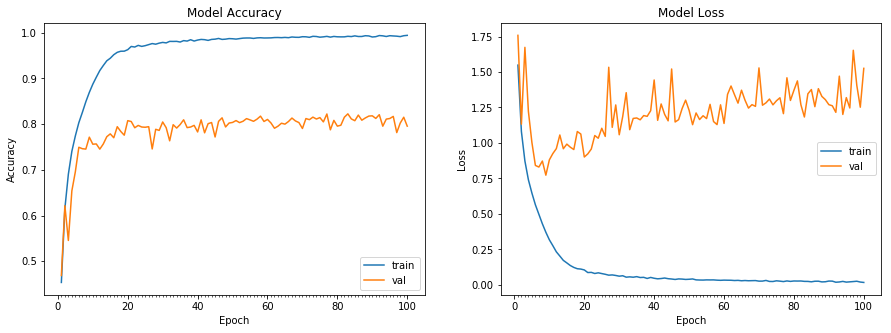

Accuracy on test data is: 79.57


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

##I changed the number of channels, just wanted to experiment what happens; by just keeping 32 and 64


In [0]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,SeparableConv2D
from keras.layers import concatenate


#5,5 seperable convolution, I consider this as depthwise seperable convolution as mentioned in the class
layer1 = SeparableConv2D(32,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_1',use_bias=False)(input)
layer1 = Dropout(0.2)(layer1)
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation('relu')(layer1)

skip_connection1 = layer1

#Normal 5,5 convolution
layer2 = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', use_bias=False,dilation_rate = 1)(layer1)
layer2 = Dropout(0.2)(layer2)
layer2 = BatchNormalization(name='norm_2')(layer2)
layer2 = Activation('relu')(layer2)

skip_connection2 = layer2

#Nomal 5,5 convolution
layer3 = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_2', use_bias=False,dilation_rate = 1)(layer2)
layer3 = Dropout(0.2)(layer3)
layer3 = BatchNormalization(name='norm_3')(layer3)
layer3 = Activation('relu')(layer3)

skip_connection3 = layer3

#matching the resolution to concatenate with layer3

layerin = concatenate([layer3,skip_connection1])


#5,5 seperable convolution, I consider this as depthwise seperable convolution as mentioned in the class
layer4 = SeparableConv2D(64,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_2',use_bias=False)(layerin)
layer4 = Dropout(0.2)(layer4)
layer4 = BatchNormalization(name='norm_4')(layer4)
layer4 = Activation('relu')(layer4)

skip_connection4 = layer4

layerin1 = concatenate([layer4,skip_connection1])

#Transition block
layer5 = MaxPooling2D(pool_size=(2, 2))(layerin1)
layer5 = Conv2D(32, (1,1),padding='same',use_bias=False)(layer5)
layer5 = BatchNormalization(name='norm_5')(layer5)
layer5 = Activation('relu')(layer5)

#3,3 seperable convolutin,depthwise
layer6 = SeparableConv2D(32,(3,3), strides=(1,1), padding = 'same',name= 'depthwise_3',use_bias=False)(layer5)
layer6 = Dropout(0.2)(layer6)
layer6 = BatchNormalization(name='norm_6')(layer6)
layer6 = Activation('relu')(layer6)

skip_connection6=layer6

layerin2 = Lambda(space_to_depth_x2)(layerin1)
layerin3=concatenate([layerin2,layer6])

#5,5 normal convolution
layer7 = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_3', use_bias=False,dilation_rate = 1)(layerin3)
layer7 = Dropout(0.2)(layer7)
layer7 = BatchNormalization(name='norm_7')(layer7)
layer7 = Activation('relu')(layer7)

skip_connection7=layer7

layerin4 =concatenate([skip_connection3,skip_connection4])
layerin4 = Lambda(space_to_depth_x2)(layerin4)
layerin5= concatenate([layerin4,skip_connection6])
layerin5=concatenate([layerin5,layer7])

#3,3 seperable convolution,depthwise
layer8 = SeparableConv2D(64,(3,3), strides=(1,1), padding = 'same',name= 'depthwise_4',use_bias=False)(layerin5)
layer8 = Dropout(0.2)(layer8)
layer8 = BatchNormalization(name='norm_8')(layer8)
layer8 = Activation('relu')(layer8)

skip_connection8=layer8

layerin6=concatenate([skip_connection1,skip_connection3])
layerin7=concatenate([layerin6,skip_connection4])
layerin7=Lambda(space_to_depth_x2)(layerin7)
layerin8=concatenate([layerin7,skip_connection6])
layerin9=concatenate([layerin8,skip_connection7])
layerin9=concatenate([layerin9,layer8])

##5,5sperable convolution,depthwise
layer9 = SeparableConv2D(64,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_5',use_bias=False)(layerin9)
layer9 = Dropout(0.2)(layer9)
layer9 = BatchNormalization(name='norm_9')(layer9)
layer9 = Activation('relu')(layer9)

skip_connection9= layer9

layerin10=concatenate([layerin3,skip_connection8])
layerin10=concatenate([layerin10,layer9])

#Transition block
layer10 = MaxPooling2D(pool_size=(2, 2))(layerin10)
layer10 = Conv2D(32, (1,1),padding='same',use_bias=False)(layer10)
layer10 = BatchNormalization(name='norm_10')(layer10)
layer10 = Activation('relu')(layer10)

skip_connection10=layer10

layerin11=Lambda(space_to_depth_x2)(skip_connection7)
layerin11=concatenate([layerin11,layer10])

#5,5 normal convolutions
layer11 = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_4', use_bias=False,dilation_rate = 1)(layerin11)
layer11 = Dropout(0.2)(layer11)
layer11= BatchNormalization(name='norm_11')(layer11)
layer11= Activation('relu')(layer11)

skip_connection11=layer11

layerin12=concatenate([skip_connection2,skip_connection4])
layerin12=Lambda(space_to_depth_x2)(layerin12)
layerin13=concatenate([layerin12,skip_connection8])
layerin13=Lambda(space_to_depth_x2)(layerin13)
layerin13=concatenate([layerin13,layer11])


#5,5 seperable convolution,depthwise
layer12 = SeparableConv2D(32,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_6',use_bias=False)(layerin13)
layer12 = Dropout(0.2)(layer12)
layer12= BatchNormalization(name='norm_12')(layer12)
layer12= Activation('relu')(layer12)

skip_connection12=layer12

layerin14=concatenate([skip_connection2,skip_connection3])
layerin14=Lambda(space_to_depth_x2)(layerin14)
layerin15=concatenate([layerin14,skip_connection6])
layerin15=Lambda(space_to_depth_x2)(layerin15)
layerin16=concatenate([layerin15,skip_connection11])
layerin16=concatenate([layerin16,layer12])

#3,3 normal convolutions
layer13 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False,dilation_rate = 1)(layerin16)
layer13 = Dropout(0.2)(layer13)
layer13= BatchNormalization(name='norm_13')(layer13)
layer13= Activation('relu')(layer13)

skip_connection13=layer13

layerin17=concatenate([skip_connection1,skip_connection3])
layerin18=concatenate([layerin17,skip_connection4])
layerin18=Lambda(space_to_depth_x2)(layerin18)
layerin19=concatenate([layerin18,skip_connection6])
layerin20=concatenate([layerin19,skip_connection8])
layerin20=Lambda(space_to_depth_x2)(layerin20)
layerin21=concatenate([layerin20,skip_connection12])
layerin21=concatenate([layerin21,layer13])

#5,5 seperable convolution,depthwise
layer14 = SeparableConv2D(64,(5,5), strides=(1,1), padding = 'same',name= 'depthwise_7',use_bias=False)(layerin21)
layer14 = Dropout(0.2)(layer14)
layer14= BatchNormalization(name='norm_14')(layer14)
layer14= Activation('relu')(layer14)

layerin22=Lambda(space_to_depth_x2)(skip_connection4)
layerin23=concatenate([layerin22,skip_connection8])
layerin23=Lambda(space_to_depth_x2)(layerin23)
layerin24=concatenate([layerin23,skip_connection12])
layerin24=concatenate([layerin24,layer14])

layer15 = Conv2D(10, (1,1),padding='same',use_bias=False)(layerin24)
layer15= Conv2D(10,8)(layer14)

layer101 = Flatten()(layer15)
output=Activation('softmax')(layer101)

In [0]:
from keras.models import Model
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
depthwise_1 (SeparableConv2D)   (None, 32, 32, 32)   171         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 32, 32, 32)   0           depthwise_1[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         dropout_13[0][0]                 
__________________________________________________________________________________________________
activation

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 152s 390ms/step - loss: 1.5144 - acc: 0.4590 - val_loss: 1.6564 - val_acc: 0.4577
Epoch 2/100
390/390 [==============================] - 145s 371ms/step - loss: 1.0921 - acc: 0.6136 - val_loss: 1.2132 - val_acc: 0.6042
Epoch 3/100
390/390 [==============================] - 144s 369ms/step - loss: 0.8928 - acc: 0.6823 - val_loss: 1.1973 - val_acc: 0.6273
Epoch 4/100
390/390 [==============================] - 144s 370ms/step - loss: 0.7589 - acc: 0.7337 - val_loss: 1.0307 - val_acc: 0.6806
Epoch 5/100
390/390 [==============================] - 144s 370ms/step - loss: 0.6633 - acc: 0.7680 - val_loss: 0.9336 - val_acc: 0.7179
Epoch 6/100
390/390 [==============================] - 144s 370ms/step - loss: 0.5849 - acc: 0.7965 - val_loss: 1.0087 - val_acc: 0.6882
Epoch 7/100
390/390 [==============================] - 144s 369ms/step - loss: 0.5216 - acc: 0.8162 - val_loss: 1.1333 - val_acc: 0.6761
Epoch 8/100
390/390 [====================

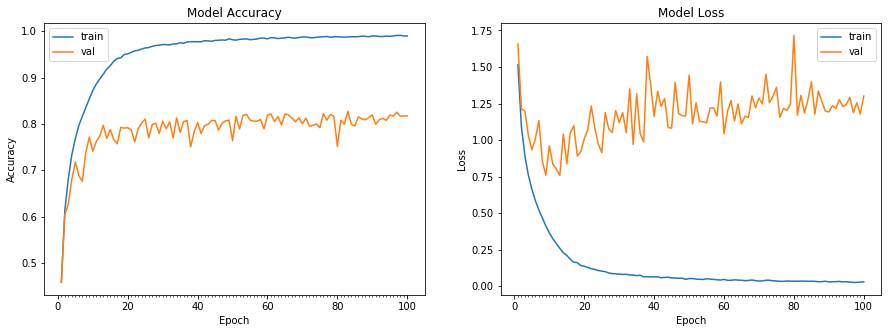

Accuracy on test data is: 81.74


In [29]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))